# Lesson 3: Decision Trees and Random Forests

In [37]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

pd.set_option("display.max_rows", 150)
pd.set_option("display.max_columns", None)
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'


In [38]:
raw_df = pd.read_csv("weather-data/weatherAUS.csv")

In [39]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

In [40]:
raw_df.dropna(subset = ['RainTomorrow'], inplace = True)

Data Preparation

/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/1351882740.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = pd.to_datetime(raw_df['Date']).dt.year, palette = 'Pastel2')


<Axes: title={'center': 'Distribution of Data Points by Year'}, xlabel='Date', ylabel='count'>

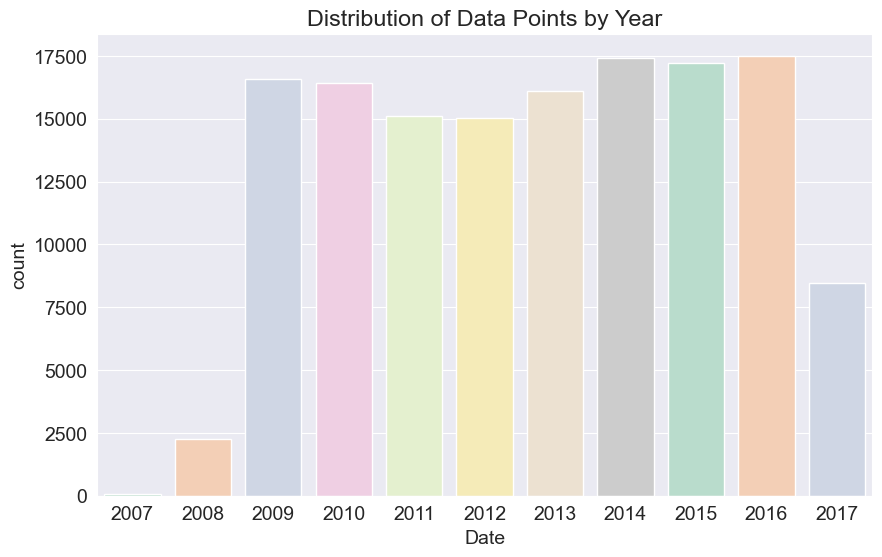

In [41]:
plt.title("Distribution of Data Points by Year")
sns.countplot(x = pd.to_datetime(raw_df['Date']).dt.year, palette = 'Pastel2')

In [42]:
#Until 2014 for the training set, 2015 for validation, and 2016-2017 for the testing set
year = pd.to_datetime(raw_df['Date']).dt.year

train_df = raw_df[year < 2015]
valid_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

In [43]:
train_df.shape, valid_df.shape, test_df.shape

((98988, 23), (17231, 23), (25974, 23))

In [44]:
raw_df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [45]:
X_columns = raw_df.columns[1:-1]
y_columns = 'RainTomorrow'

In [46]:
X_train = train_df[X_columns]
y_train = train_df[y_columns]

In [47]:
X_valid = valid_df[X_columns]
y_valid = valid_df[y_columns]

In [48]:
X_test = test_df[X_columns]
y_test = test_df[y_columns]

In [49]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((98988, 21), (98988,), (17231, 21), (17231,), (25974, 21), (25974,))

In [50]:
numerical_columns = X_train.select_dtypes(include = np.number).columns.to_list()
categorial_columns = X_train.select_dtypes(include = object).columns.to_list()

In [51]:
numerical_columns

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm']

In [52]:
categorial_columns

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

Imputing Values

In [53]:
from sklearn.impute import SimpleImputer

In [54]:
imputer = SimpleImputer(strategy = 'mean').fit(X_train[numerical_columns])

In [55]:
X_train[numerical_columns] = imputer.transform(X_train[numerical_columns])
X_valid[numerical_columns] = imputer.transform(X_valid[numerical_columns])
X_test[numerical_columns] = imputer.transform(X_test[numerical_columns])

/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/1259501027.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_columns] = imputer.transform(X_train[numerical_columns])
/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/1259501027.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[numerical_columns] = imputer.transform(X_valid[numerical_columns])
/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/1259501027.py:3: SettingWithCopyWarning: 

In [57]:
X_train[numerical_columns].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

Scaling Values

In [58]:
from sklearn.preprocessing import MinMaxScaler

In [59]:
scaler = MinMaxScaler(feature_range = (0, 1)).fit(X_train[numerical_columns])

In [60]:
X_train[numerical_columns] = scaler.transform(X_train[numerical_columns])
X_valid[numerical_columns] = scaler.transform(X_valid[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/174089709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[numerical_columns] = scaler.transform(X_train[numerical_columns])
/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/174089709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid[numerical_columns] = scaler.transform(X_valid[numerical_columns])
/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/174089709.py:3: SettingWithCopyWarning: 
A va

In [62]:
X_train[numerical_columns].describe().loc[['min', 'max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Encoding Categorical Data

In [63]:
categorial_columns

['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

In [64]:
from sklearn.preprocessing import OneHotEncoder

In [67]:
X_train.fillna('Unknown', inplace = True)
X_valid.fillna('Unknown', inplace = True)
X_test.fillna('Unknown', inplace = True)

/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/2890657415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna('Unknown', inplace = True)
/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/2890657415.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_valid.fillna('Unknown', inplace = True)
/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/2890657415.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [69]:
encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore').fit(X_train[categorial_columns])

In [72]:
encoder.categories_

[array(['Adelaide', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek',
        'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
        'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart',
        'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport',
        'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle',
        'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF',
        'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale',
        'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville',
        'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia',
        'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera'],
       dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'Unknown', 'W', 'WNW', 'WSW'], dtype=object),
 array(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
        'SSW', 'SW', 'Unknown', 'W', 'WNW', 'WSW'], dtype=

In [73]:
encoded_columns = encoder.get_feature_names_out(categorial_columns).tolist()

In [74]:
encoded_columns

['Location_Adelaide',
 'Location_Albany',
 'Location_Albury',
 'Location_AliceSprings',
 'Location_BadgerysCreek',
 'Location_Ballarat',
 'Location_Bendigo',
 'Location_Brisbane',
 'Location_Cairns',
 'Location_Canberra',
 'Location_Cobar',
 'Location_CoffsHarbour',
 'Location_Dartmoor',
 'Location_Darwin',
 'Location_GoldCoast',
 'Location_Hobart',
 'Location_Katherine',
 'Location_Launceston',
 'Location_Melbourne',
 'Location_MelbourneAirport',
 'Location_Mildura',
 'Location_Moree',
 'Location_MountGambier',
 'Location_MountGinini',
 'Location_Newcastle',
 'Location_Nhil',
 'Location_NorahHead',
 'Location_NorfolkIsland',
 'Location_Nuriootpa',
 'Location_PearceRAAF',
 'Location_Penrith',
 'Location_Perth',
 'Location_PerthAirport',
 'Location_Portland',
 'Location_Richmond',
 'Location_Sale',
 'Location_SalmonGums',
 'Location_Sydney',
 'Location_SydneyAirport',
 'Location_Townsville',
 'Location_Tuggeranong',
 'Location_Uluru',
 'Location_WaggaWagga',
 'Location_Walpole',
 'Locat

In [76]:
X_train[encoded_columns] = encoder.transform(X_train[categorial_columns])
X_valid[encoded_columns] = encoder.transform(X_valid[categorial_columns])
X_test[encoded_columns] = encoder.transform(X_test[categorial_columns])

/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/2557274667.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[encoded_columns] = encoder.transform(X_train[categorial_columns])
/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/2557274667.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[encoded_columns] = encoder.transform(X_train[categorial_columns])
/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_38444/2557274667.py:1: PerformanceWarning: DataFrame is high

In [77]:
#Final Step, Drop the textual categorical columns
X_train = X_train[numerical_columns + encoded_columns]
X_valid = X_valid[numerical_columns + encoded_columns]
X_test = X_test[numerical_columns + encoded_columns]

In [78]:
X_train

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_Unknown,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_Unknown,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_Unknown,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_No,RainToday_Unknown,RainToday_Yes
0,0.516509,0.517241,0.001617,0.064161,0.531618,0.294574,0.229885,0.275862,0.71,0.22,0.449587,0.463696,0.888889,0.490495,0.494577,0.525391,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.375000,0.559387,0.000000,0.064161,0.531618,0.294574,0.045977,0.252874,0.44,0.25,0.497521,0.475248,0.478672,0.490495,0.501085,0.574219,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.504717,0.570881,0.000000,0.064161,0.531618,0.310078,0.218391,0.298851,0.38,0.30,0.447934,0.490099,0.478672,0.222222,0.583514,0.552734,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.417453,0.614943,0.000000,0.064161,0.531618,0.139535,0.126437,0.103448,0.45,0.16,0.613223,0.557756,0.478672,0.490495,0.520607,0.617188,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.

Training Decision Trees

In [79]:
from sklearn.tree import DecisionTreeClassifier

In [80]:
model = DecisionTreeClassifier(random_state = 42)

In [81]:
model = model.fit(X_train, y_train)